# Covid-19 Tracker(Updated)

The objective of this notebook is to track Covid-19 wave and variant during the progression of the covid19(Sars-Cov II) pandemic. To do so, we work on
1. **Knownledge on the inflection point**
2. **Knownledge on the epidemic curve**
3. **EDA, geospatial analysis, Covid-19 wave and variant in**

    3.1. **Independent variant**
    - *UK: United Kingdom.*
    - *SA: South Africa.*
    - *US: United State America.*
    - *BZ: Brazil*
    
    3.2. **Combinatory variant**
    - *IND: India*
    - *VIET: Vietnam*
4. **Tracking wave and variant**
6. **Conclusion**

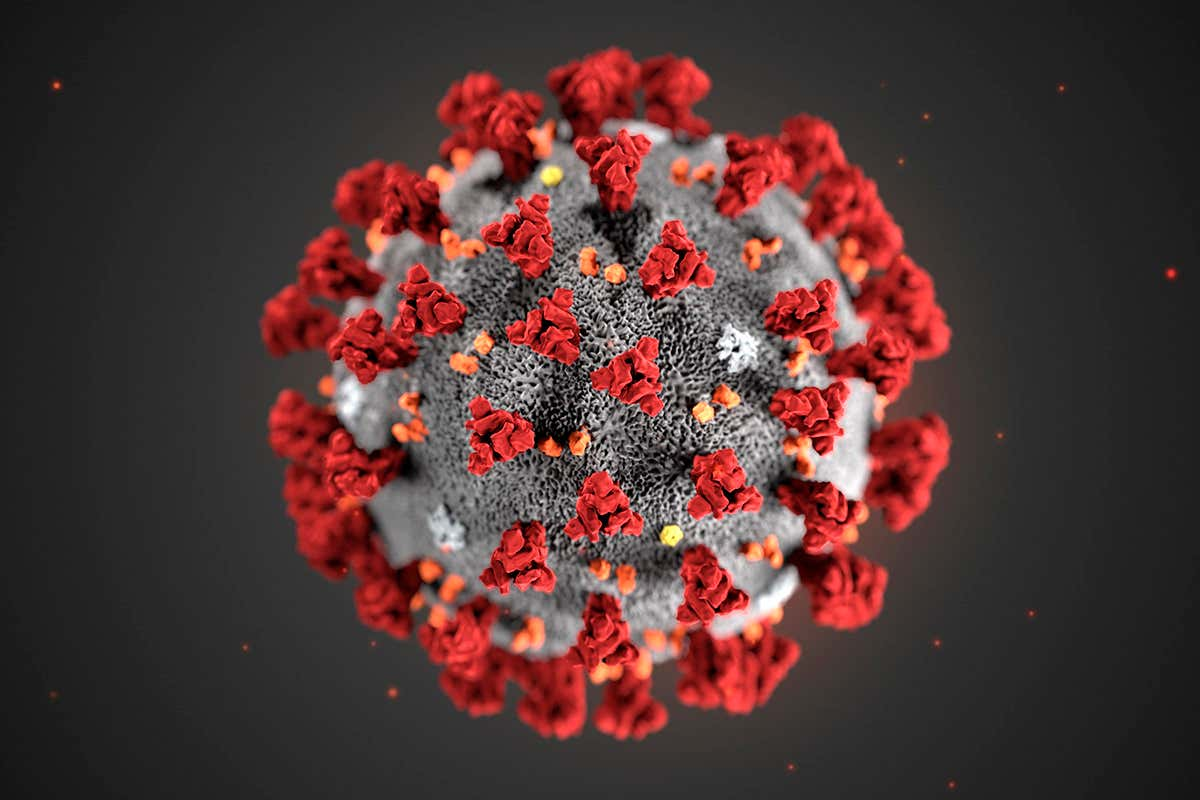

<h3 style='background:yellow; border:0; color:Blue'><center>Warning<center><h3><p> This notebook is long and track how different variant spreads and behave  in their country respectively. So take all the time you need to read and find out. If you don't agree on a procedure please comment and I will try to respond. Thanks for reading.</p>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# import package
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels as sm
import folium as fl
from pathlib import Path
from sklearn.impute import SimpleImputer
import geopandas as gpd
import mapclassify as mpc
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.offline as py
import plotly.express as px
import cufflinks as cf
import tensorflow as tf

In [ ]:
%matplotlib inline
pd.options.plotting.backend = "plotly" 
#pd.plotting.register_matplotlib_converters()
gpd.plotting.plot_linestring_collection
sns.set()
warnings.filterwarnings('ignore')
cf.go_offline()
cf.set_config_file(offline=True)

# Inflection point

**Inflection point** is a point of the curve where the  curvature changes its sign

For the graph of a function of differentiability class $C^{2}$ ($f$, its first derivative $f^{'}$, and its second derivative $f^{''}$, exist and are continuous), the condition $f^{''} = 0$ can also be used to find an **inflection point** since a point of $f^{''} = 0$ must be passed to change $f^{''}$ from a positive value (**concave upward**) to a negative value (**concave downward**) or vise versa as $f^{''}$ is continuous; an inflection point of the curve is where $f^{''} = 0$ and **changes its sign at the point (from positive to negative or from negative to positive)**

1. if $f^{''}(x) > 0$ we have concave upward  or convex.
2. if $f^{''}(x) < 0$ we have concave downward or concave.
3. if $f^{''}(x_{0})= 0$ in changing a sign  and $f^{'''}(x_{0}) \neq 0 $ we obtain inflection point.

**Sufficient condition**

- $x_{0}$ is an inflection point iff  $f^{''}(x_{0}+\epsilon)$ and $f^{''}(x_{0}-\epsilon)$ have opposite signs in the neighborhood of $x_{0}$. (Bronshtein and Semendyayev 2004, p.231).

*NB: inflection point help us to track wave*

# Epidemic curve

**The epidemic curve** is a graphical representation of the number of cases of a disease or health event over time, in a population, place and over a given period.

The feature of an epidemic curve are:

**expanse** That is, the interval between the first case and the last case, allows us to estimate the total duration of the epidemic.

**The median** divides the epidemic curve into two halves of equal numbers. We are more specifically interested in the date of onset of the median case.

**The mode** or **dominant value of a statistical series**, is the value which has the greatest number. A distribution is unimodal if it has a marked maximum, a peak, which corresponds to the mode.

**Incubation time** This is the interval between the acquisition of the infection (contact with the agent) and the appearance of the first symptoms

etc...

In [ ]:
raw_confirmed = pd.read_csv('/kaggle/input/covid19-data-from-john-hopkins-university/RAW_global_confirmed_cases.csv')
raw_deaths = pd.read_csv('/kaggle/input/covid19-data-from-john-hopkins-university/RAW_global_deaths.csv')

In [ ]:
raw_confirmed.head()

In [ ]:
raw_deaths.head()

In [ ]:
#create new function
def transform_data(df=None, name=None):
    return df[df['Country/Region'] == name].iloc[:, 4:].T

# EDA, geospatial analysis, Covid-19 wave and variant.

## Variant independant

## United State American: CAL.20C or DELTA

In [ ]:
us_conf = pd.read_csv('/kaggle/input/covid19-data-from-john-hopkins-university/RAW_us_confirmed_cases.csv')
us_death = pd.read_csv('/kaggle/input/covid19-data-from-john-hopkins-university/RAW_us_deaths.csv')
us_meta = pd.read_csv('/kaggle/input/covid19-data-from-john-hopkins-university/CONVENIENT_us_metadata.csv')

**Confirmed case**

In [ ]:
us_conf.tail()

**Deaths**

In [ ]:
us_death.tail()

In [ ]:
us_meta.tail()

In [ ]:
us = transform_data(df=raw_confirmed, name='US')

In [ ]:
us.columns=['confirmed']

In [ ]:
us['deaths'] = transform_data(df=raw_deaths, name='US').values

In [ ]:
us.tail()

### Country: variant, epidemic curve, inflection point.

In [ ]:
us_fig = us.plot(y='confirmed', title='USA Covid-19 spreading')
us_fig.show()

In [ ]:
us_fig_dea = us.plot(y='deaths', title='USA Covid-19 spreading')
us_fig_dea.show()

### epidemic curve

Let's $f(t)$ the function that describe the evolution of **covid 19 confirmed case**  over the time. We define $N(t)$ the function that describe the behaviour of the **incidence** such that:

$$
N(t) = \dfrac{f(t+\Delta t) - f(t)}{\Delta t}
$$ 

For second derivative, we use this formula as this:
$$
SD(t) = \dfrac{N(t+\Delta t) - N(t)}{\Delta t}
$$ where $\Delta t$ is the periods.  In our case, we take  30 days.

In [ ]:
#we define new confirmed
us['incidence'] = us.confirmed.diff(30)/30
us['death_rate'] = us.deaths.diff(30)/30
us['second_derivative'] = us.incidence.diff(30)/30

In [ ]:
us.index = pd.to_datetime(us.index)

### Descriptive analysis and visualization

**Describe**

In [ ]:
us[['incidence','death_rate']].describe()

**correlation**

In [ ]:
us.corr()

**mode, skew, kurtosis**

In [ ]:
us[['incidence','death_rate']].mode()

In [ ]:
us[['incidence','death_rate']].skew()

In [ ]:
us[['incidence','death_rate']].kurtosis()

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(2,2, 1)
ax2 = plt.subplot(2,2,2)
sns.distplot(us['incidence'], bins=15, ax=ax1)
sns.distplot(us['death_rate'], bins=15, ax=ax2)
ax1.set_title('US: Incidence distribution.')
ax2.set_title('US: death_rate distribution.')
plt.show()

#### Incidence and death rate date median

#### median

In [ ]:
incid_date_median = us.index[len(us.index)//2 + 1]
incid_date_median

#### Outlier

In [ ]:
us_fig_box1 = us.iloc[:,2].plot(kind='box', title='Incidence Covid-19 boxplot in US')
us_fig_box1.show()

In [ ]:
us_fig_box2 = us.iloc[:,3].plot(kind='box', title='Incidence and Covid-19 boxplot in US')
us_fig_box2.show()

<div class="alert alert-info" ><h4>Note</h4><p>Outlier can help us to detect a date where abnormal observation occurs in spreading of the disease. We can define this function below.</p></div>

In [ ]:
def detect_outlier(data):
    """
        This function detect outlier
    """
    data = data.dropna()
    q25, q75 = np.percentile(data,25), np.percentile(data, 75)
    IQR = q75 - q25
    cutoff = 1.5*IQR
    lower, upper = q25 - cutoff, q75 + cutoff
    
    def detect(row):
        if row >= lower and row <= upper:
            return 'intlier'
        else:
            return 'outlier'
        
    return data.apply(detect)

In [ ]:
us['isOutlier'] = detect_outlier(us.incidence)
us['dea_isOutlier'] = detect_outlier(us.death_rate)

In [ ]:
figsca = px.scatter(us, x=us.index, y='incidence', title = 'US incidence Covid-19')
figsca.show()

<div class="alert alert-info"><h4>Note</h4><p>This curve have 5 maxima and 4 minima.</p></div>

In [ ]:
figdea = px.scatter(us, x=us.index, y='death_rate', title='US death rate Covid-19')
figdea.show()

## US Covid-19 wave 

In [ ]:
sec_us_fig = us.second_derivative.plot(title='second derivative')
sec_us_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>We are going to find an inflection point by using a Bronshtein and Semendyayev sufficient condition.</p></div>

In [ ]:
def find_inflexion_interval(data=None):
    """
        This function find inflection point 
    """
    
    date = data.dropna().index # Observation date 
    
    inflection = [] # inflection set 
    for i in range(1, len(date)):
        today = date[i-1] #today 
        yesterday = date[i]
        
        actual_data = data[data.index == today].second_derivative.values
        previous_data = data[data.index == yesterday].second_derivative.values
        
        if actual_data*previous_data < 0:
            inflection.append([today, yesterday])
            #print(actual_data*previous_data)
        else:
            continue
            
            
    return inflection

In [ ]:
us_inflex = find_inflexion_interval(data=us)
us_inflex

In [ ]:
""" We have 5 intervals where there exist 3 maximun and 2 minimun then the number of wave is 3 waves. i.e 5-2. 
USA undergoes the third wave of Covid-19 which allow to detect a new variant Covid-19.   """

### USA Geospatial Analysis

In [ ]:
confirmed = pd.merge(us_meta[['Province_State', 'Admin2', 'Population']] , us_conf, on=['Province_State', 'Admin2'])
deaths =us_death.copy()

In [ ]:
confirmed.head()

#### Which province state/Population are more contaminated by the covid-19 disease in USA?

In [ ]:
ObsDate = sorted(list(set(confirmed.columns) - set(['Province_State', 'Admin2', 'UID', 'iso2','iso3','code3','FIPS','Country_Region','Lat','Long_',
                                                      'Combined_Key']))) 

In [ ]:
state = confirmed.groupby('Province_State')[ObsDate].agg('sum').reset_index().set_index(['Population', 'Province_State'])

In [ ]:
state.columns = pd.to_datetime(state.columns).date

In [ ]:
state.sort_index(axis=1, ascending=True, inplace=True)

In [ ]:
state = state.reset_index()

In [ ]:
state.head()

In [ ]:
last_date = state.iloc[:, -1].name

In [ ]:
state.sort_values(by=[last_date], ascending=False, inplace=True)

In [ ]:
us_state = px.bar(state, text='Population', y=last_date, x='Province_State',
                 title='US-Province State Covid-19 confirmed cases ranking.')
us_state.update_traces(texttemplate='%{text:.2s}', textposition='inside')
us_state.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
us_state.show()

In [ ]:
figus = px.scatter(state, x='Population', y=last_date, text='Province_State', size_max=60)

figus.update_traces(textposition='top center')

figus.update_layout(
    height=600,
    title_text=f'Confirmed cases vs Population size: USA the, {last_date}.'
)

figus.show()

<div class="alert alert-info"><h4>Note</h4><p>Population increases and confirmed case increases</p></div> 

In [ ]:
#compute correlation
corr = state.corr()['Population'][1:].plot.area(title='Correlation between confirmed case day and US Population.')
corr.show()

<div class="alert alert-info"><h4>Note</h4><p>
This curve shows that the longer the disease lasts, the most populated region is the one with the most confirmed cases of covid 19. we can see this graph below.<p></div>

In [ ]:
plt.figure(figsize=(15,5))
sns.regplot(x=state.Population, y=state.iloc[:, -1], order=1)
for _, u in state[state.iloc[:,-1] > 10000].iloc[:, [0,1,-1]].iterrows():
    plt.annotate(text=u[1], xy=(u[0], u[2]))
plt.title(f'US Prevalence Covid19 disease: {state.iloc[:, -1].name}.')
plt.xlabel('Population')
plt.ylabel('Confirmed case')
plt.xlim(0, 40055000)
plt.show()


<div class="alert alert-info"><h4>Note</h4><p>
Prevalence in US can be written, according to the graph:
$$
y(t) = a(t) n,
$$
where $a(t) \in \mathcal{R} \quad \forall t \in [0, T]$ is coefficient of the prevalence function, .$y(t)$ is a confirmed case, $n$ is a number of population  in each province state.</p></div<

<div  class="alert alert-success"><h4>We learn</h4>
<p>1. New York, California, Texas and Florida are the four province state most contaminated by covid 19 in USA</p>
<p>2. The longer the disease lasts, the most populated region is the one with the most confirmed cases of covid 19.</p></div>

#### Which population does covid19 kill the most in the USA?

In [ ]:
deaths.head()

In [ ]:
date = sorted(list(set(deaths.columns) - set(['Province_State', 'Admin2', 'UID', 'iso2','iso3','code3','FIPS','Country_Region','Lat','Long_',
                                                      'Combined_Key', 'Population']))) 

In [ ]:
fatality = deaths.groupby('Province_State')[date].agg('sum')

In [ ]:
fatality.columns = pd.to_datetime(fatality.columns).date

In [ ]:
fatality.sort_index(axis=1, ascending=True, inplace=True)

In [ ]:
fatality.head()

In [ ]:
fig_fatal = px.bar(fatality, y=last_date, x=fatality.index, title='US Death Covid-19.')
fig_fatal.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_fatal.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig_fatal.show()

In [ ]:
fatal_transpose = fatality.T

In [ ]:
ft = fatal_transpose[['California', 'Texas', 'Florida','New York']].plot(title='US covid19 Deaths ')
ft.show()

<div class="alert alert-info"><h4>Note</h4><p>
    California is the province state where its population are most killed by Covid-19.</p></div> 

### California state

In this section,  we are studying the spreading of coronavirus and  new variant at California state. This state is important to study  because the US american have identified  new SARS-COV II variant with 5 mutations called **CAL.20C** and now **Delta**.

source: [CIDRAP](https://www.cidrap.umn.edu/news-perspective/2021/02/new-covid-variant-5-mutations-identified-california)  

In [ ]:
calif_conf = confirmed[confirmed.Province_State == 'California']
calif_deat = deaths[deaths.Province_State == 'California'] 

In [ ]:
calif_conf.tail()

In [ ]:
calif_deat.head()

In [ ]:
last_day = calif_conf.iloc[:,-1].name
last_day

In [ ]:
#transforms
calif_conf.drop(columns=['Province_State', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'], inplace=True)
calif_deat.drop(columns=['Province_State', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'], inplace=True)

#### What town is most contamined?  

In [ ]:
ccf = calif_conf.set_index(['Admin2'])[['Population', last_day]].plot.barh(
    title=f"Town's SARS-COV II: {last_day}.", color='Population')
ccf.show()

<div class="alert alert-info"><h4>Note</h4><p>
    Los Angeles is the town most  contaminated by the SARS-COV II.</p></div>

In [ ]:
plt.figure(figsize=(15,5))
sns.regplot(x=calif_conf.Population, y=calif_conf.iloc[:,-1], order=2)
for i, v in calif_conf[calif_conf.Population > 0.2e7].iloc[:, [0,1,-1]].iterrows():
    plt.annotate(text=v[0], xy=(v[1], v[2]))
plt.title(f'Sars-Cov II Prevalence California: {calif_conf.iloc[:,-1].name}')
plt.show()

<div class="alert alert-info"><h4>Note</h4><p> Strong correlation between Population size and number of the confirmed case.</p></div>

#### How is density?

In [ ]:
plt.figure(figsize=(15,5))
cal = calif_conf[(calif_conf.Long_!=0) & (calif_conf.Lat!=0)]
plt.scatter(x=cal.Long_, y=cal.Lat, edgecolors='black', linewidths=0.8, alpha=0.75, c=cal.Population, cmap='Reds', s=cal.iloc[:,-1]/1000)
plt.colorbar(label='Population')
plt.title(f'California cities Sars-Cov II: Cases and Population size: {calif_conf.iloc[:, -1].name}.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

xmin = cal.iloc[:,-1].min()/1000
xmax = cal.iloc[:,-1].max()/1000
xmiddle = (xmax+xmin)/4
for _, v in calif_conf[calif_conf.Population > 0.2e7].iterrows():
    plt.annotate(text=v['Admin2'], xy=(v['Long_']+0.135, v['Lat']), bbox = dict(boxstyle="round", fc="0.8"))
    
for case in [xmin, xmiddle, xmax]:
    plt.scatter([], [], c='k', alpha=0.3, s=case, label=str(1000*case))
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='SARS-COV II confirmed cases')
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>
This is a proof that SARS-COV II likes to contaminate the city who have huge population and high economic. Example Los Angeles.</p></div> 

In [ ]:
#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(confirmed, lat=confirmed.Lat, lon=confirmed.Long_, color='Population', size=last_day, 
                        hover_name='Admin2', zoom=2, 
                mapbox_style='open-street-map', title='Confirmed cases Covid-19 US map.')
fig.show()

<div class="alert alert-info"><h4>Note</h4><p> The circle size shows the number of confirmed case and color shows a population size.</p></div>

In [ ]:
fidea = px.scatter_mapbox(deaths, lat=deaths.Lat, lon=deaths.Long_, color=last_day, size=last_day, 
                        hover_name='Admin2', zoom=2,
                mapbox_style='open-street-map', title='Deaths Covid-19 US map.')
fidea.show()

<div class="alert alert-info"><h4>Note</h4><p> The cercle size and color show the deaths of Sars-Cov II.</p></div>

### California wave

In [ ]:
deaths_california = fatal_transpose['California']

In [ ]:
deaths_california.columns = ['deaths']

In [ ]:
deaths_california['new_death'] = deaths_california.diff(30)/30

In [ ]:
ne_deat_cal_fig = deaths_california.new_death.plot.line(title='California Covid-19 deaths rate.')
ne_deat_cal_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
    Clear graph, <b>wave = new variant Covid-19</b>; we see 3 maxima where <b>maxima(1 st wave) and maxima(2nd wave) are less than maxima(3rd maxima)</b>.</p> 
    <p>1. First wave reachs to the maximun after 5 months.</p>
    <p>2. Second wave reachs to the maximun after 3 months.</p>
    <p>3. Third wave reachs to the maximun after 2 months.</p>

<p>We can say that <b>Cal.20C spread quickly and is very deadly. The gap between first maxima and second maxima of the deaths is very large</b>.</p></div> 

## United Kingdom: B.1.1.7 or Delta

It was september 2020 that UK detected a new variant covid-19.

In [ ]:
uk_raw = raw_confirmed[raw_confirmed['Country/Region'] == 'United Kingdom']
uk_dea = raw_deaths[raw_deaths['Country/Region'] == 'United Kingdom']

In [ ]:
uk_raw.head()

In [ ]:
uk_dea = uk_dea[uk_dea.iloc[:, -1] >= 0.0]

In [ ]:
uk_raw = uk_raw[uk_raw.iloc[:, -1] >= 0.0]

In [ ]:
uk_raw.info()

In [ ]:
uk_last_day = uk_raw.iloc[:, -1].name
uk_fig = px.scatter_mapbox(uk_raw, lat=uk_raw.Lat, lon=uk_raw.Long, color=last_day, size=last_day, 
                        hover_name='Country/Region', zoom=0,
                mapbox_style='open-street-map', title='Confirmed cases Covid-19 UK and ROW map.')
uk_fig.show()

In [ ]:
uk_fid = px.scatter_mapbox(uk_dea, lat=uk_dea.Lat, lon=uk_dea.Long, color=last_day, size=last_day, 
                        hover_name='Country/Region', zoom=0, 
                mapbox_style='open-street-map', title='Deaths Covid-19 UK and ROW map.')
uk_fid.show()

In [ ]:
uk_conf = uk_raw.groupby('Country/Region')[uk_raw.iloc[:, 4:].columns].agg('sum')

In [ ]:
uk =pd.DataFrame()

In [ ]:
uk['confirmed'] = uk_conf.T['United Kingdom']
uk['deaths'] = uk_dea.groupby('Country/Region')[uk_dea.iloc[:, 4:].columns].agg('sum').T['United Kingdom']

In [ ]:
uk.tail()

### Epidemiological situation in UK: epidemic curve

In [ ]:
conf_fig = uk.plot.line(y='confirmed', title='UK Covid-19 confirmed case')
conf_fig.show()

In [ ]:
deat_fig = uk.deaths.plot.line(title='UK Covid-19 deaths. ')
deat_fig.show()

### Descriptive analysis: Incidence, death rate, second_derivative

In [ ]:
uk['incidence'] = uk.confirmed.diff(30)/30
uk['death_rate'] = uk.deaths.diff(30)/30
uk['second_derivative'] = uk.incidence.diff(30)/30

In [ ]:
uk[['incidence', 'death_rate', 'second_derivative']].describe()

In [ ]:
uk[['incidence', 'death_rate']].skew()

In [ ]:
uk[['incidence', 'death_rate']].kurtosis()

In [ ]:
uk.corr()

### UK visualization

In [ ]:
inc_uk_fig = uk.incidence.plot.line(title='UK Covid-19 incidence curve.')
inc_uk_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
    We see 3 behaviors of disease september 2020 is the bifurcation point and also new variant detected.</p></div>

In [ ]:
deat_uk_fig = uk.death_rate.plot.line(title='UK Covid-19 death rate curve.')
deat_uk_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
For this graph, we see three behaviors where september 2020 is the bifurcation point. new varant covid-19 is very fast and kill most.</p></div>

### Outlier

In [ ]:
box_inci_fig = uk[['incidence', 'death_rate']].plot.box(title='UK Covid-19 incidence and new deaths boxplot.')
box_inci_fig.show()

In [ ]:
plt.figure(figsize=(15,5))
ax11 = plt.subplot(2,2, 1)
ax21 = plt.subplot(2,2,2)
sns.distplot(uk['incidence'], bins=15, ax=ax11)
sns.distplot(uk['death_rate'], bins=15, ax=ax21)
ax11.set_title('UK: Incidence distribution.')
ax21.set_title('UK: death_rate distribution.')
plt.show()

### UK Covid-19 wave.

In [ ]:
uk_inflex = find_inflexion_interval(data=uk)
uk_inflex

In [ ]:
sec_dev_uk_fig = uk.second_derivative.plot.line(title='UK Covid-19 wave curve.')
sec_dev_uk_fig.show()

UK have 4 Covid-19 waves.

## South Africa: B.1.351

In October 2020, SA have detected a Covid-19 B.1.351 variant. 

In [ ]:
sa = transform_data(df=raw_confirmed, name='South Africa')

In [ ]:
sa.columns = ['confirmed']
sa['deaths'] = transform_data(df=raw_deaths, name='South Africa')

In [ ]:
sa.tail()

### Epidemiological situation in South Africa.

In [ ]:
sa_conf_fig = sa.plot.line(y='confirmed', title='Covid-19 confirmed case in South Africa.')
sa_conf_fig.show()

In [ ]:
sa_dea_fig = sa.plot.line(y='deaths', title='Covid-19 deaths in South Africa.')
sa_dea_fig.show()

### Epidemic curve: Incidence and new death.

In [ ]:
sa['incidence'] = sa.confirmed.diff(30)/30
sa['death_rate'] = sa.deaths.diff(30)/30
sa['second_derivative'] = sa.incidence.diff(30)/30

In [ ]:
#descriptive analysis
sa[['incidence', 'death_rate']].describe()

In [ ]:
sa[['incidence', 'death_rate']].skew()

In [ ]:
sa[['incidence', 'death_rate']].kurtosis()

In [ ]:
sa.corr()

#### Outlier

In [ ]:
box_sa_fig = sa[['incidence', 'death_rate']].plot.box(title='Incidence and new death boxplot.')
box_sa_fig.show()

In [ ]:
plt.figure(figsize=(15,5))
ax111 = plt.subplot(2,2, 1)
ax211 = plt.subplot(2,2,2)
sns.distplot(sa['incidence'], bins=15, ax=ax111)
sns.distplot(sa['death_rate'], bins=15, ax=ax211)
ax111.set_title('SA: Incidence distribution.')
ax211.set_title('SA: death_rate distribution.')
plt.show()

### Visualization

In [ ]:
sa_inc_fig = sa.incidence.plot.line(title='South Africa Covid-19 Incidence.')
sa_inc_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
    This graph speaks clearly, three curves = three waves(variants).</p>
    <p>1. The first wave reachs its maximun after 6 months (see curves).</p>
<p>2. The second wave (new variant) reachs its maximun after 3 months where Max(1st wave) is less than Max(2nd wave). <b>B.1.351 variant spreads very fast and most people are contaminated</b>. Also Kill more. see below.</p></div>

In [ ]:
sa_dea_fig = sa.death_rate.plot.line(title='South Africa Covid-19 deaths rate.')
sa_dea_fig.show()

### South Africa Covid-19 wave

In [ ]:
sa_sec_dev_fig = sa.second_derivative.plot.line(title='South Africa Covid-19 wave.')
sa_sec_dev_fig.show()

In [ ]:
sa_inflex = find_inflexion_interval(data=sa)
sa_inflex

# Brazil: P.1

Brazil is the second country in this world very more contamined by Covid19  after USA. 

## Epidemiological situation in Brazil

In [ ]:
bz = transform_data(df=raw_confirmed, name='Brazil')

In [ ]:
bz.columns = ['confirmed']
bz['deaths'] = transform_data(df=raw_deaths, name='Brazil')

In [ ]:
bz.tail()

In [ ]:
bz_conf_fig = bz.plot.line(y='confirmed', title='Covid-19 confirmed case in Brazil.')
bz_conf_fig.show()

In [ ]:
bz_dea_fig = bz.plot.line(y='deaths', title='Covid-19 deaths in Brazil.')
bz_dea_fig.show()

## Epidemic curve: Incidence and new deaths

In [ ]:
bz['incidence'] = bz.confirmed.diff(30)/30
bz['death_rate'] = bz.deaths.diff(30)/30
bz['second_derivative'] = bz.incidence.diff(30)/30

In [ ]:
#descriptive analysis
bz[['incidence', 'death_rate']].describe()

In [ ]:
bz[['incidence', 'death_rate']].skew()

In [ ]:
bz[['incidence', 'death_rate']].kurtosis()

In [ ]:
bz.corr()

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.3)
bz_cols = ['incidence', 'death_rate']
for i, u in enumerate(bz_cols):
    ax = fig.add_subplot(1, 2, i+1)
    sns.histplot(bz[u], bins=10, ax=ax, kde=True, stat='probability')
    ax.set_title('Brazil: ' + u + ' histogram.')
plt.show()

### Outlier

In [ ]:
box_sa_fig = bz[['incidence', 'death_rate']].plot.box(title='Incidence and new death boxplot.')
box_sa_fig.show()

## Visualization

In [ ]:
bz_inc_fig = bz.incidence.plot.line(title='Brazil Covid-19 Incidence.')
bz_inc_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
    This graph speaks clearly, two curves = two waves(variants). With bifurcation point at 11/10/2020.
</div>

In [ ]:
bz_dea_fig = bz.death_rate.plot.line(title='Brazil Covid-19 deaths rate.')
bz_dea_fig.show()

## Covid19 wave.

In [ ]:
bz_sec_dev_fig = bz.second_derivative.plot.line(title='Brazil Covid-19 random wave.')
bz_sec_dev_fig.show()

# Combinatory variant

# India: B.1.617

B.1.617 is one of variant of the SARS-COV II. It was first identified in India on 5 October 2020 and is a "double mutation" variant. B.1.617 = L452R(detected in california) + E484Q(looks like mutation E484K: present in South African and Brazilian variants).

In [ ]:
indi = transform_data(df=raw_confirmed, name='India')

In [ ]:
indi.columns = ['confirmed']
indi['deaths'] = transform_data(df=raw_deaths, name='India')

In [ ]:
indi.tail()

In [ ]:
ind_conf_fig = indi.plot.line(y='confirmed', title='Covid-19 confirmed case in India.')
ind_conf_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
    This graph speaks clearly, two concave curves 7/21/2020 and 4/5/2021. B.1.617 was detected at 05/10/2020.
</div>

In [ ]:
ind_dea_fig = indi.plot.line(y='deaths', title='Covid-19 deaths in India.')
ind_dea_fig.show()

## Epidemic curve: Incidence and  deaths rate.

In [ ]:
indi['incidence'] = indi.confirmed.diff(30)/30
indi['death_rate'] = indi.deaths.diff(30)/30
indi['second_derivative'] = indi.incidence.diff(30)/30

In [ ]:
#descriptive analysis
indi[['incidence', 'death_rate']].describe()

In [ ]:
indi[['incidence', 'death_rate']].skew()

In [ ]:
indi[['incidence', 'death_rate']].kurtosis()

Incidence is outlier.

In [ ]:
indi.corr()

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.subplots_adjust(wspace=0.3)
ind_cols = ['incidence', 'death_rate']
for i, u in enumerate(ind_cols):
    ax = fig1.add_subplot(1, 2, i+1)
    sns.histplot(indi[u], bins=20, ax=ax, kde=True, stat='probability')
    ax.set_title('India: ' + u + ' histogram.')
plt.show()

## India: visualization

In [ ]:
ind_inc_fig = indi.incidence.plot.line(title='India Covid-19 Incidence.')
ind_inc_fig.show()

In [ ]:
ind_inc_fig = indi.death_rate.plot.line(title='India Covid-19 death rate.')
ind_inc_fig.show()

## Covid19 wave: India

In [ ]:
ind_sec_dev_fig = indi.second_derivative.plot.line(title='India Covid-19 wave.')
ind_sec_dev_fig.show()

# Vietnam hybrid variant

Vietnam variant is the combination of the Indian  and UK variants and can spreads quickl by air.

In [ ]:
viet = transform_data(df=raw_confirmed, name='Vietnam')

In [ ]:
viet.columns = ['confirmed']
viet['deaths'] = transform_data(df=raw_deaths, name='Vietnam')

In [ ]:
viet.tail()

In [ ]:
viet_conf_fig = indi.plot.line(y='confirmed', title='Covid-19 confirmed case in Vietnam.')
viet_conf_fig.show()

<div class="alert alert-info"><h4>Note</h4><p>
    Clearly, two concave curves 8/1/2020 and 4/5/2021. Hybrid variant was detected at 29/5/2021.
</div>

## Epidemic curve: Incidence and deaths rate

In [ ]:
viet['incidence'] = viet.confirmed.diff(30)/30
viet['death_rate'] = viet.deaths.diff(30)/30
viet['second_derivative'] = viet.incidence.diff(30)/30

In [ ]:
#descriptive analysis
viet[['incidence', 'death_rate']].describe()

In [ ]:
viet[['incidence', 'death_rate']].skew()

In [ ]:
viet[['incidence', 'death_rate']].kurtosis()

In [ ]:
viet.corr()

In [ ]:
fig12 = plt.figure(figsize=(15,5))
fig12.subplots_adjust(wspace=0.3)
viet_cols = ['incidence', 'death_rate']
for i, u in enumerate(viet_cols):
    ax = fig12.add_subplot(1, 2, i+1)
    sns.histplot(viet[u], bins=20, ax=ax, kde=True)
    ax.set_title('Vietnam: ' + u + ' histogram.')
plt.show()

## Vietnam visualization

In [ ]:
viet_inc_fig = viet.incidence.plot.line(title='Vietnam Covid-19 Incidence.')
viet_inc_fig.show()

In [ ]:
viet_inc_fig = viet.death_rate.plot.line(title='Vietnam Covid-19 death rate.')
viet_inc_fig.show()

## Covid 19 wave: Vietnam

In [ ]:
viet_sec_dev_fig = viet.second_derivative.plot.line(title='Vietnam Covid-19 wave.')
viet_sec_dev_fig.show()

<div class="alert alert-success"><h4>We learn</h4>
    <p>1. Covid-19 more contaminates regions with high population density.</p>
    <p>2. Each wave of covid-19 reflects the birth of a new variant.</p>
    <p>3. New variants Covid-19 spread quickly and are very deadly.</p>
    <p>4. The coronavirus variants are different from one country to another.</p>
    <p>5. The variants are more and more resistant.</p>
    <p>6. Each variant is different to others.</p>
    <p>7. Combinatory variant are different. </p></div>  
    

# Comparison of the covid19  variants

## Compare incidence

In [ ]:
country_variant = {"USA":us, 'UK':uk, 'South Africa':sa, 'Brazil':bz, 'India':indi, 'Vietnam':viet}

In [ ]:
figur = plt.figure(figsize=(20,20))
figur.subplots_adjust(wspace=0.2, hspace=0.2)
for i, u in enumerate(country_variant.keys()):
    ctry = country_variant[u]
    if u not in ['USA']:
        ctry.index = pd.to_datetime(ctry.index)
    ax = figur.add_subplot(3, 2, i+1)
    sns.scatterplot(x=ctry.index, y=ctry.incidence, ax=ax)
    ax.set_xlabel('dateObservation')
    ax.set_ylabel('incidence')
    ax.set_title(f'{u}: covid19 incidence',  fontdict={'fontsize':18})

## Compare death rate

In [ ]:
figur1 = plt.figure(figsize=(20,20))
figur1.subplots_adjust(wspace=0.2, hspace=0.2)
for i, u in enumerate(country_variant.keys()):
    ctry = country_variant[u]
    if u not in ['USA']:
        ctry.index = pd.to_datetime(ctry.index)
    ax = figur1.add_subplot(3, 2, i+1)
    sns.scatterplot(x=ctry.index, y=ctry.death_rate, ax=ax)
    ax.set_xlabel('dateObservation')
    ax.set_ylabel('death rate')
    ax.set_title(f'{u}: covid19 death rate', fontdict={'fontsize':18})

## Compare wave

In [ ]:
figur2 = plt.figure(figsize=(20,20))
figur2.subplots_adjust(wspace=0.2, hspace=0.2)
for i, u in enumerate(country_variant.keys()):
    ctry = country_variant[u]
    if u not in ['USA']:
        ctry.index = pd.to_datetime(ctry.index)
    ax = figur2.add_subplot(3, 2, i+1)
    sns.scatterplot(x=ctry.index, y=ctry.second_derivative, ax=ax)
    ax.set_xlabel('dateObservation')
    ax.set_ylabel('wave')
    ax.set_title(f'{u}: covid19 wave', fontdict={'fontsize':18})

# Tracking wave and variant.

In this place, we are going to track wave (variant) by following this method:

1. compute new case Covid-19.
2. find maxima set.
3. find minima set between the lower maxima and upper maxima.
4. discover the behavior of each wave.
5. compute correlation between new case $(N)$ and confirmed case $(C)$. If $N = f(C)$ (strong correlation) then find the approximate function using deep neural network.
6. make prediction by using Runge-Kutta 4. $$N(t)=\dfrac{dC}{dt} = f_{dnn}(C)$$


In [ ]:
us['new_case'] = us.confirmed.diff()
uk['new_case'] = uk.confirmed.diff()
sa['new_case'] = sa.confirmed.diff()

#### US, UK, SA correlation

In [ ]:
us.corr()

In [ ]:
uk.corr()

In [ ]:
sa.corr()

### Find maxima and minima  point.

In [ ]:
def find_maxima_point(data=None, n=60):
    """
    This function look for the maxima in the incidence curve.
    @params: data Pandas dataframe
    @params: number of days give interval to find maxima
    """
    # initialization
    maxima_set  = [] #define maxima set
    values = [] # take a maxima
    x = 0.0 #help to store
    j = 0 # iteration
    
    #check if an index is object type
    if data.index.dtype == 'object':
        data.index = pd.to_datetime(data.index)
    
    #find maxima
    for i, row in data.iterrows():
        
        y = row.incidence
        if y > x:
            x = y
        
        # append only maxima
        if x > y and j%n == 0:
            values.append(x)
            
        j += 1
    
    #finalize
    for u in np.unique(values):
        maxima_set.append((u, data[data.incidence == u].index[0]))
    
    
    return maxima_set

In [ ]:
def find_minima_point(data=None, maxima=None):
    """
    This function find a minima point
    @params data pandas dataframe
    @params maxima set.
    """
    
    #check if index is object type
    if data.index.dtype == 'object':
        data.index = pd.to_datetime(data.index)
    
    m = len(maxima) #lenght of maxima set
    minima_set = []
    
    for i in range(m-1):
        
        x1 = maxima[i][1] #lower maxima
        x2 = maxima[i+1][1] #upper maxima
        
        #find a minima between maxima
        xmin = data[(data.index > x1) & (data.index < x2)].incidence.min()
        
        #store
        minima_set.append((xmin, data[data.incidence == xmin].index[0]))
        
    return minima_set

### For USA

In [ ]:
us_maxima = find_maxima_point(data=us)

In [ ]:
us_maxima

In [ ]:
us_minima = find_minima_point(data=us, maxima=us_maxima)

In [ ]:
us_minima

<div class="alert alert-info"><h4>Note</h4><p>Each maxima give a wave and minima give the end of the previous wave and the start of the next wave.</p></div>

### USA: Wave(variant) behavior.  

In [ ]:
 start_date = us.index.min()

In [ ]:
print('======================= US wave behavior=================================\n')
print(f'1. The first wave reachs to the maxima: {round(us_maxima[0][0],1)} after {us_maxima[0][1]-start_date }.')
print(f'2. The second wave reachs to the maxima: {round(us_maxima[1][0],1)} after {us_maxima[1][1] - us_minima[0][1]}.')
print(f'3. The third wave reachs to the maxima: {round(us_maxima[2][0],1)} after {us_maxima[2][1] - us_minima[1][1]}.')
print(f'4. The gap between 1st wave and 2nd wave equal to {round(us_maxima[1][0] - us_maxima[0][0], 1)} confirmed case.')
print(f'5. The gap between 2st wave and 3rd wave equal to {round(us_maxima[2][0] - us_maxima[1][0], 1)} confirmed case.')

<div class="alert alert-info"><h4>Note</h4><p>We must know that each wave have an agent i.e viruse. 1st wave (100 days) have Sars-cov II, 3rd wave (116 days) have variant CAL.20C. 2nd wave(51 days) nothing.<p>
    <p> We can remark that a variant is detected if it reachs to his maxima above 100 days.<p></div>

### For UK

In [ ]:
uk_maxima = find_maxima_point(data=uk, n=30)

In [ ]:
uk_maxima

In [ ]:
uk_minima = find_minima_point(data=uk, maxima=uk_maxima)

In [ ]:
uk_minima

### UK: Wave(variant) behavior.  

In [ ]:
print('======================= UK wave behavior=================================\n')
print(f'1. The first wave reachs to the maxima: {round(uk_maxima[0][0],1)} after {uk_maxima[0][1]-start_date }.')
print(f'2. The second wave reachs to the maxima: {round(uk_maxima[1][0],1)} after {uk_maxima[1][1] - uk_minima[0][1]}.')
print(f'3. The third wave reachs to the maxima: {round(uk_maxima[2][0],1)} after {uk_maxima[2][1] - uk_minima[1][1]}.')
print(f'4. The gap between 1st wave and 2nd wave equal to {round(uk_maxima[1][0] - uk_maxima[0][0], 1)} confirmed case.')
print(f'5. The gap between 2st wave and 3rd wave equal to {round(uk_maxima[2][0] - uk_maxima[1][0], 1)} confirmed case.')

<div class="alert alert-info"><h4>Note</h4><p>A variant is detected if its wave reachs to his maxima above 100 days.</p></div>

### For SA

In [ ]:
sa_maxima = find_maxima_point(data=sa, n=30)

In [ ]:
sa_maxima

In [ ]:
sa_minima = find_minima_point(data=sa, maxima=sa_maxima)

In [ ]:
sa_minima

In [ ]:
print('======================= SA wave behavior=================================\n')
print(f'1. The first wave reachs to the maxima: {round(sa_maxima[0][0], 1)} after {sa_maxima[0][1]-start_date}.')
print(f'2. The second wave reachs to the maxima: {round(sa_maxima[1][0], 1)} after {sa_maxima[1][1] - sa_minima[0][1]}.')
print(f'3. The gap between 1st wave and 2nd wave equal to {round(sa_maxima[1][0] - sa_maxima[0][0], 1)} confirmed case.')

<div class="alert alert-info"><h4>Note</h4><p> South Africa had detected a new variant on  september 2020.</p></div>

<div class="alert alert-success"><h4>We learn</h4>
    <p>1. Variant Covid-19 in the country is different with others everywhere in the world.</p>
    <p>2. Some variants appears and suddenly disappears quickly,  other lasts.</p>
    <p>1. Spreading of Covid-19 is different everywhere in the world. </p></div>

# Approximate function using neural network and Runge-Kutta method to predict covid19 confirmed case.

We take USA.

In [ ]:
us.corr()['new_case']

<div class="alert alert-info"><h4>Note</h4><p>I take only confirmed case such that we have $$\dfrac{dC}{dt} = f_{nn}(C)$$.</p></div>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
model = keras.Sequential([
    layers.Dense(units=200, activation='relu', input_shape=[1]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units=150, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units=1)
])

In [ ]:
model.summary()

In [ ]:
#data
data= us[['confirmed']].fillna(0)
target = us.new_case.fillna(0)

In [ ]:
X = data/data.max() #scaling data
Y = target/target.max()# scaling target

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X.values,  Y.values, test_size=0.2)

In [ ]:
xtrain.shape

In [ ]:
#compile our model
model.compile(loss='mae', metrics=['mse'], optimizer='adam')

In [ ]:
history = model.fit(xtrain, ytrain, batch_size=32, epochs=250, validation_split=0.2)

In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(250), history.history['loss'],label='loss')
plt.plot(range(250), history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('Loss function')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(250), history.history['mse'],label='mse')
plt.plot(range(250), history.history['val_mse'], label='val_mse')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('MSE metric')
plt.show()

In [ ]:
model.evaluate(xtest, ytest)

In [ ]:
r2_score(ytest, model.predict(xtest))

## Runge-Kutta method.

In [ ]:
def integrate(F, x, y, xstop, h):
    def run_kut4(F, x, y, h):
        K0 = h*F(x, y)
        K1 = h*F(x + h/2.0, y + K0/2.0)
        K2 = h*F(x + h/2.0, y + K1/2.0)
        K3 = h*F(x + h, y + K2)
        return (K0+ 2.0*K1 + 2.0*K2 + K3)/6.0
    
    X = []
    Y = []
    
    X.append(x)
    Y.append(y)
    
    while x < xstop:
        
        h = min(h, xstop - x)
        y = y + run_kut4(F, x, y, h)
        x = x + h
        
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

<div class = "alert alert-info"><h4>Note</h4><p>We can also use Stochastics differential equation (SDE).<p></div>

In [ ]:
def f_nn(t, x):
    return model.predict(x)

In [ ]:
x = 0.0
xstop = 0.1
y = np.array([1.0])
h = 0.01

In [ ]:
X, Y = integrate(f_nn, x, y, xstop, h)

In [ ]:
prediction = pd.DataFrame()

In [ ]:
prediction['confirmed'] =  data.max().values[0]*Y[1:, 0]

In [ ]:
prediction.index = pd.date_range(start=data.index.max()+ pd.Timedelta(1, unit='D') , periods=Y.shape[0]-1)

In [ ]:
data_predict = pd.concat([data, prediction])

In [ ]:
data_predict.tail(12)

In [ ]:
predict_fig = data_predict.plot.line(title='Covid-19 confirmed case prediction for USA.')
predict_fig.show()

<div class="alert alert-info"><h4>Note</h4><p> We make prediction combining Deep Neural Network with Runge-Kutta method. Here h is our random hyperparameter, it tells us how disease spread.</p></div>

# Conclusion (progress)

We are at the end of a very long work which has given us a lot of information on Covid-19.

What we can remember here is that **Sars-Cov II spreads best in areas with a high population density (example California, Los Angeles), the coronavirus II spreads differently in the world.**

**Each wave originates from a new variant of Covid-19**. The latter is detected if and only if **its propagation is long**; other not because short or brief. 

**Each variant has its own specificity depending on the place of its existence (the South African variant is different from that of the English and the Americans)**. 

In the USA, **the contamination of the provinces of states by Covid-19 is done according to the size of the population i.e. the most populous states are the most contaminated. (example California, New York, Florida, Texas, Pennsylvania, ..)**.

# Upnext

**TO BE CONTINUE..**